In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from scipy.stats import skewnorm 
from scipy.optimize import minimize 
from numpy.linalg import inv

2. Sea 𝑍 la variable aleatoria con distribución skew-normal de parámetro 𝑎 = 10. Consideremos
la función 𝑓 : R → R dada por 𝑓 (𝑥) = 2𝑥 − 1. Sean 𝑋 ∼ U (0, 1) y 𝑌 B 𝑓 (𝑋) + 𝑍.

1

(a) Fijemos 𝑛 = 100. Tomar muestras 𝑥1, . . . , 𝑥𝑛 de 𝑋 y 𝑧1, . . . , 𝑧𝑛 de 𝑍 y calcular 𝑦𝑖 = 𝑓 (𝑥𝑖) + 𝑧𝑖
,
con 1 ≤ 𝑖 ≤ 𝑛. Realizar un ajuste lineal de la forma 𝑌 = 𝑋 𝛽1 + 𝛽0 + 𝜖 a partir de los samples
(𝑥1, 𝑦1), . . . , (𝑥𝑛, 𝑦𝑛) generados.

(b) Repetir el paso anterior𝑚 = 30 veces para obtener𝑚 pares de coeficientes 𝛽0 y 𝛽1, es decir,𝑚
samples de ˆ𝛽0 y𝑚 samples de ˆ𝛽1. ¿Diríamos que estas distribuciones empíricas son normales?
Hacer histogramas para comprobarlo.

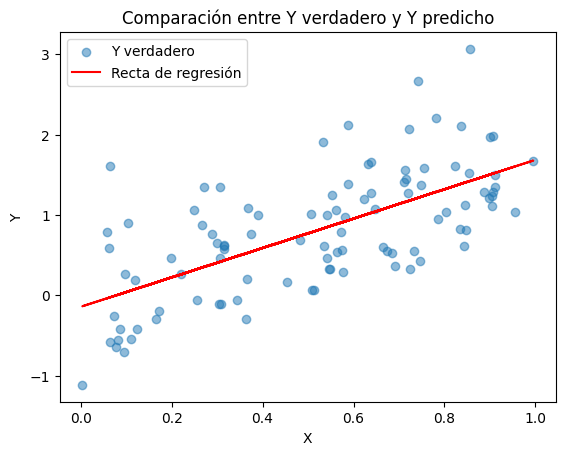

In [2]:
n = 100

def f(x):
    return 2*x-1

X= np.random.uniform(0,1,n)
Z = skewnorm.rvs(a=10, size=n)

Y = f(X) + Z

mod = np.vstack([X, np.ones(len(X))]).T
b1, b0 = np.linalg.inv(mod.T @ mod) @ mod.T @ Y

Y_pred = b1 * X + b0

plt.scatter(X, Y, label='Y verdadero', alpha = 0.5)
plt.plot(X, b1 * X + b0, color='red', label='Recta de regresión')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Comparación entre Y verdadero y Y predicho')
plt.show()

Text(0, 0.5, 'frecuencia')

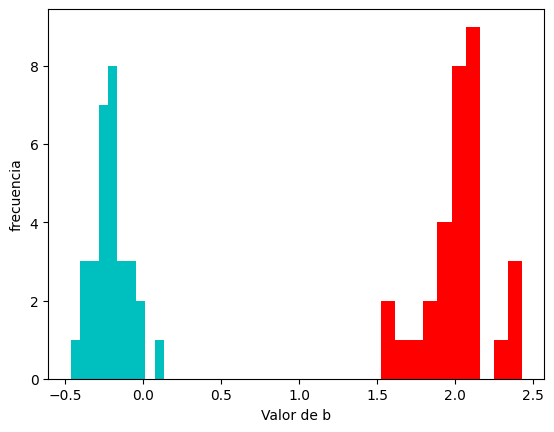

In [3]:
betas_0 = []
betas_1 = []

for i in range(31):
    X= np.random.uniform(0,1,n)
    Z = skewnorm.rvs(a=10, size=n)

    Y = f(X) + Z
    
    mod = np.vstack([X, np.ones(len(X))]).T
    b1, b0 = np.linalg.inv(mod.T @ mod) @ mod.T @ Y

    betas_0.append(b0)
    betas_1.append(b1)

plt.hist(betas_0, label="b0", color="c")
plt.hist(betas_1, label="b1", color="r")
plt.xlabel("Valor de b")
plt.ylabel("frecuencia")

en la mayoria de los casos, la distribucion empirica se ve como una forma normal 

3) Modelemos la cantidad de likes diarios que recibe un posteo en Instagram los 30 días posteriores
a su publicación. Para eso, consideramos muestras (𝑥1, 𝑦1), . . . , (𝑥𝑛, 𝑦𝑛) de las variables aleatorias
𝑋, los días desde el posteo, que toma valores entre 0 y 30, y 𝑌, la cantidad de likes por día, que
es un proceso de Poisson que debe reflejar de manera razonable el fenómeno (por ejemplo, los
primeros días se dan muchos likes y después van decayendo en el tiempo).

(a) Generar muestras sintéticas 𝑥 = (𝑥1, . . . , 𝑥𝑛), 𝑦 = (𝑦1, . . . , 𝑦𝑛) para 𝑛 = 100. Graficar 𝑦 vs 𝑥.

(b) Proponer el Modelo Lineal Generalizado de Poisson y encontrar estimaciones puntuales para
los parámetros de regresión 𝛽.

(c) Determinar el error estándar de cada parámetro de regresión

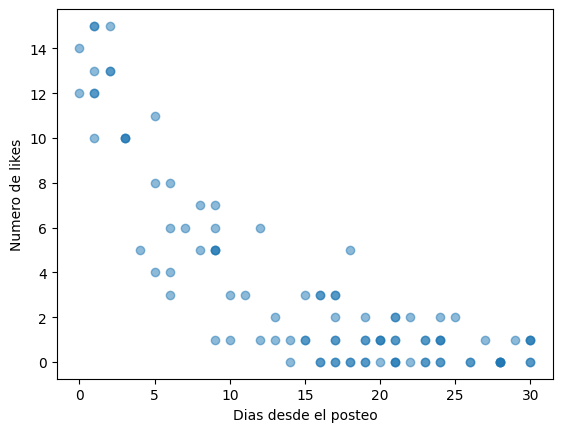

In [4]:
n = 100

X = np.random.randint(0, 31, n)
Y = np.random.poisson(15 * np.exp(-0.13*X) ,n) 
#quiero que decaiga con el tiempo, por eso necesito una exponencial negatica que lo relacione con los valores de X, el -0.13 y el 15 son simplemente numeros que fui probando hasta que quedo algo que me parecia razonable

plt.scatter(X,Y, alpha=0.5)
plt.xlabel("Dias desde el posteo")
plt.ylabel("Numero de likes")
plt.show()

Al saber que la distribucion es de Poisson, uso el link canonico que es log(mu), y planteo que y = b0 + b1 * x, como Y depende de b0 y b1, uno el estimador de maxima verosimilitud para encontrarlos. Si minimizo la likelihood negativa estoy maximizando la positiva

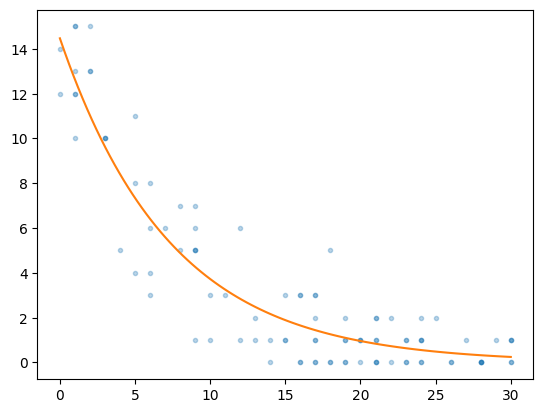

In [5]:
def neg_log_likelihood_poisson(beta, X,Y): 
    lambda_ = np.exp(np.dot(X,beta))
    return -np.sum(Y * np.log(lambda_) - lambda_)

X_int = np.column_stack([np.ones_like(X), X])
res_p = minimize(neg_log_likelihood_poisson,[0,0], args= (X_int, Y))
b0, b1 = res_p.x

fig, ax = plt.subplots()
ax.plot(X,Y,".", alpha=0.3)
X_estimacion = np.linspace(0,30,100)
mu_estaimacion= np.exp(b0 + b1 * X_estimacion)
ax.plot(X_estimacion, mu_estaimacion)



Para determinar el error estandar de cada parametro, utilizo la matriz de Fisher

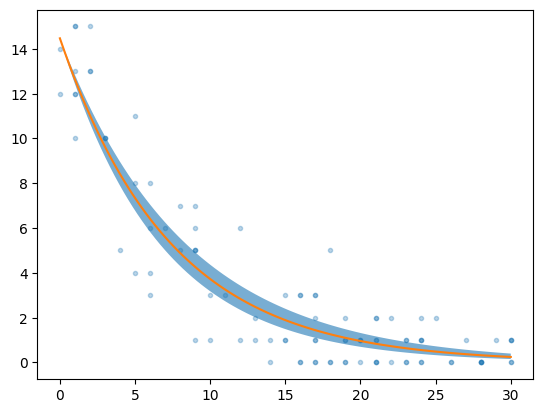

In [6]:
mu = np.exp(X_int @ res_p.x)
W = np.diag(mu)

Fisher_info_matrix = X_int.T @ W @ X_int
cov_matrix = inv(Fisher_info_matrix)
sem_b1 = np.sqrt(cov_matrix[1, 1])
sem_b0 = np.sqrt(cov_matrix[0, 0])

fig, ax = plt.subplots()
ax.plot(X,Y,".", alpha=0.3)
X_estimacion = np.linspace(0,30,100)
mu_estaimacion= np.exp(b0 + b1 * X_estimacion)
mu_alto = np.exp(b0 + (b1 + sem_b1 *1.96) * X_estimacion)
mu_bajo = np.exp(b0 + (b1 - sem_b1 *1.96) * X_estimacion)
ax.plot(X_estimacion, mu_estaimacion)
ax.fill_between(X_estimacion, mu_bajo, mu_alto, alpha=0.6)